In [1]:
import numpy as np
import nibabel as nib

from utils.class_SAM import SAMInferer
from utils.base_classes import Points, Prompt
import utils.prompt as prUt
import utils.analysis as anUt
from utils.image import read_im_gt
from utils.interactivity import iterate_2d

# Obtain model
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

sam_inferer = SAMInferer(checkpoint_path, device)

# Load img, gt
img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/imagesTr/BDMAP_00000001_0000.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/labelsTr/BDMAP_00000001.nii.gz'
class_label = 2 

gt_unprocessed = nib.load(gt_path).get_fdata()
gt_unprocessed = np.where(gt_unprocessed == class_label, 1, 0)

img, gt = read_im_gt(img_path, gt_path, class_label)


In [2]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n_clicks = 5
point_prompt = prUt.get_pos_clicks2D_row_major(gt, n_clicks, seed = seed)
segmentation = sam_inferer.predict(img_path, point_prompt, use_stored_embeddings=True).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Performing inference on slices: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


0.018462632809659173

In [3]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)
segmentation = sam_inferer.predict(img_path, box_prompt, use_stored_embeddings=True).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 12/12 [00:00<00:00, 148.91it/s]


0.6321341328003554

In [4]:
# Experiment: get 3d bbox and slice it to feed it in 2d axially
box_prompt = prUt.get_bbox3d_sliced(gt)

segmentation = sam_inferer.predict(img_path, box_prompt, use_stored_embeddings=True).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 12/12 [00:00<00:00, 156.49it/s]


0.337035618536959

In [6]:
# Experiment: line interpolation
n_slices = 5
interpolation = 'linear'
point_prompt = prUt.point_interpolation(gt, n_slices, interpolation)

segmentation = sam_inferer.predict(img_path, point_prompt, use_stored_embeddings=True).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 12/12 [00:00<00:00, 134.45it/s]


0.01727214350732833

In [8]:
# Experiment: box interpolation
n_boxes = 5

seed_boxes = prUt.get_seed_boxes(gt, n_boxes)
box_prompt = prUt.box_interpolation(seed_boxes)
segmentation = sam_inferer.predict(img_path, box_prompt, use_stored_embeddings=True).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 12/12 [00:00<00:00, 153.42it/s]


0.6770276833414279

In [4]:
# Experiment: Point propagation
seed = 11121
n_clicks = 5

# Get seed prompt and bounds
seed_point = prUt.get_seed_point(gt, n_clicks, seed)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation, prompt = prUt.point_propagation(sam_inferer, img_path, seed_point, slices_to_infer, seed, n_clicks, use_stored_embeddings=True)
print(anUt.compute_dice(gt,segmentation))


Propagating up: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


0.015677466398998946


In [10]:
# Experiment: Box propagation
seed_box = prUt.get_seed_box(gt)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation, prompt = prUt.box_propagation(sam_inferer, img_path, seed_box, slices_to_infer, use_stored_embeddings=True)

print(anUt.compute_dice(gt,segmentation))

Propagating up: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

0.4862864606007836


In [13]:
# Iteratively improve starting from random points
seed = 11121
n_clicks = 5
point_prompt = prUt.get_pos_clicks2D_row_major(gt, n_clicks, seed = seed)
segmentation, low_res_logits = sam_inferer.predict(img_path, point_prompt, return_low_res_logits = True, use_stored_embeddings=True, transform = False)
anUt.compute_dice(segmentation, gt)


initial_prompt = point_prompt
condition = 'dof'
dof_bound = 90
seed_sub = np.random.randint(10**5)
dice_scores, dofs, segmentations, prompts = iterate_2d(sam_inferer, img_path, gt, segmentation, low_res_logits, initial_prompt, pass_prev_prompts=True, use_stored_embeddings = True,
                                                                         init_dof = 5, dof_bound = dof_bound, seed = seed_sub, detailed = True)

0.018462632809659173


TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

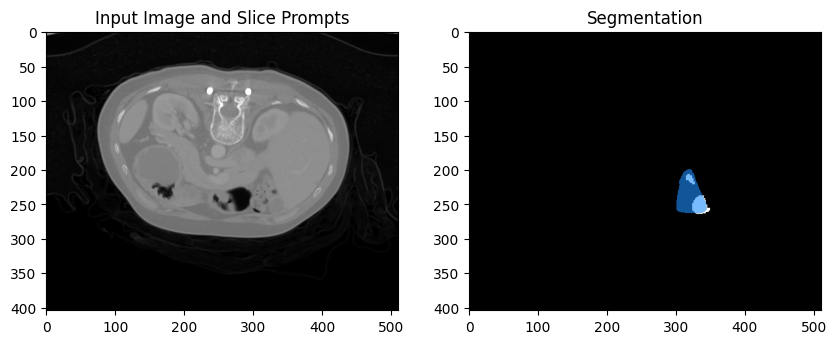

0.4159938485198001

In [17]:
# Slice visualisation (points):
slice_idx = 150
anUt.show_seg_row_major(slice_idx, img, gt, segmentation) #, pts_prompt= pts_prompt, box_prompt = box_prompt)